In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-medium"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Goole has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = False,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of handsets, with the latest model coming out this week, and while it's a bit disappointing that they're going with a plastic body, there are some really interesting features in the latest iPhone.  
p(answer):  p(' devices'[4410])=0.2049, p(' phones'[9512])=0.1882, p(' smartphones'[18151])=0.1707, p(' hands'[2832])=0.0887, p(' products'[3186])=0.0367

Goole has released Pixel 7
Goole has released Pixel 7.1.1 which brings a few fixes and security fixes.  Google has also updated its Android Marshmallow operating system for Nexus 6P, Nexus 9 and Pixel. This update brings a few security and stability
p(answer):  p(' and'[290])=0.1817, p(','[11])=0.0804, p('.'[13])=0.0659, p(' Plus'[8227])=0.0247, p(' on'[319])=0.0194

I am taking a Machine Learning class
I am taking a Machine Learning class at my alma mater, and I am going to learn a lot of stuff.  I'm going to take a class called 'Machine 

## Dataloader (the `GoEmotions` dataset)

In [5]:
df = pd.read_csv("../Data/IMDB_50K_Reviews/archive/IMDB Dataset.csv")
df = df.sample(frac = 1)
df.head()

,review,sentiment
43083,What we have here is a film about how the purs...,negative
13797,Jared Diamond made a point in the first episod...,negative
25228,"Some people might call ""Paulie"" a kids' movie,...",positive
37655,The 1960's were a time of change and awakening...,negative
4044,This movie is the last straw in a list of film...,negative


In [6]:
for index, row in df.iterrows():
    print(row["review"])
    print(row["sentiment"])
    break

What we have here is a film about how the pursuit of money & revenge can corrupt your soul... or something like that. Guy Ritchie, a director known for his reworking of the gangster genre, bites off more than he can chew with this one.<br /><br />His use of modern film noir to tackle the theme of a man setting himself free by swallowing his pride, being nice to his enemy & giving away all his money falls flat on it's face. When Jason Statham's character no longer fears Ray Liotta, it apparently drives Liotta crazy enough to blow his head off in the final scene. Why? Basically you cannot set up a mafiosi like the Liotta character, who has presumably got to his station in life by displaying the kind of ruthless behaviour evident throughout the film, only then to have him driven to suicide by nothing more than a pitying smile on the face of Statham's character.<br /><br />Before anyone starts to say I'm missing the point... I'm not. I get it OK? Opt out of the quest for riches & you'll fi

In [7]:
train_df = df[0:30000]
validation_df = df[30000:40000]
test_df = df[40000:50000]

In [8]:
train_df.shape, validation_df.shape, test_df.shape

((30000, 2), (10000, 2), (10000, 2))

In [9]:
from torch.utils.data import DataLoader, Dataset

import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("\\", "")
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

# cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

class GoEmotions(Dataset):
    def __init__(self, data_frame):
        self.x = []
        self.y = []

        for index, row in data_frame.iterrows():
            self.x.append("<REVIEW>: " + cleanhtml(row["review"]) + " <SENTIMENT>")
            self.y.append(" " + row["sentiment"])
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [10]:
training_dataset = GoEmotions(train_df)
validation_dataset = GoEmotions(validation_df)
test_dataset = GoEmotions(test_df)

len(training_dataset), len(validation_dataset), len(test_dataset)

(30000, 10000, 10000)

In [11]:
batch_size = 2

training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Tuning

In [12]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
unembedder = "lm_head"

In [13]:
###############################################################################################################
prefix_size = 20
num_epochs = 10
###############################################################################################################

learning_rate = 5e-4
warmup_steps = 200
weight_decay = 0

optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Promt-Tuned_CLF__IMDB_50K/{MODEL_NAME}"

In [14]:
embedder_module = nethook.get_module(model, embedder)
lm_head = nethook.get_module(model, unembedder)

In [15]:
import random

init_words = ["sentiment", "elephant", "review"]
def get_initial_prefix(prefix_size = 5):
    words = random.choices(init_words, k=prefix_size)
    sentence = " " + " ".join(words)
    tokenized = tokenizer(sentence, return_tensors = "pt").to(next(model.parameters()).device)
    return embedder_module(tokenized['input_ids'])

get_initial_prefix(7).shape

torch.Size([1, 7, 1024])

In [16]:
model.config.n_embd

1024

In [17]:
import copy

soft_embeddings = get_initial_prefix(prefix_size)
init_state = copy.deepcopy(soft_embeddings)
soft_embeddings.requires_grad  = True

print((init_state - soft_embeddings).norm())

# def insert_prompt_embeddings(output, layer, soft_embeddings = soft_embeddings):
#     if(layer != embedder):
#         return output
#     print(output.requires_grad, soft_embeddings.requires_grad)
#     prefix_size = soft_embeddings.shape[1]
#     for batch in output:
#         batch[0:prefix_size] = soft_embeddings
#     return output

def insert_prompt_embeddings_2(output, layer, soft_embeddings = soft_embeddings):
    if(layer != embedder):
        return output
    prefix_size = soft_embeddings.shape[1]
    arr = []
    for batch in output:
        added = torch.cat((soft_embeddings[0], batch[prefix_size:, :]))
        arr.append(added)
    return torch.stack(arr)

inner_rep = torch.randn([2, 23, model.config.n_embd]).to(next(model.parameters()).device)
prefix_added = insert_prompt_embeddings_2(inner_rep, embedder)

print(inner_rep.shape, prefix_added.shape)
(inner_rep[..., prefix_size:, :] - prefix_added[..., prefix_size:, :]).norm()

tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
torch.Size([2, 23, 1024]) torch.Size([2, 23, 1024])


tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)

In [18]:
print(soft_embeddings)

tensor([[[-0.0402, -0.0731,  0.0385,  ...,  0.0422, -0.0059, -0.0381],
         [-0.2413, -0.0916, -0.0155,  ...,  0.0148, -0.0138, -0.1585],
         [-0.0402, -0.0731,  0.0385,  ...,  0.0422, -0.0059, -0.0381],
         ...,
         [-0.2413, -0.0916, -0.0155,  ...,  0.0148, -0.0138, -0.1585],
         [-0.1227, -0.0664,  0.1448,  ...,  0.0807,  0.0043, -0.0249],
         [-0.2413, -0.0916, -0.0155,  ...,  0.0148, -0.0138, -0.1585]]],
       device='cuda:0', requires_grad=True)


In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup


# optimizer = AdamW(
#     # model.parameters(),
#     [v for _, v in tunable_weights.items()],
#     lr = learning_rate,
# )
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
# )


for name, w in model.named_parameters():
    w.requires_grad = True

optimizer = torch.optim.Adam(
    [soft_embeddings],
    lr=learning_rate,
    weight_decay=weight_decay,
)

num_prompts_optimized = 0
training_loss_track = []
validation_loss_track = []


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for reviews, sentiments in tqdm(training_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        # add soft tokens
        prefix_tokens = torch.ones(len(reviews), prefix_size, dtype = int).to(next(model.parameters()).device) * model.config.bos_token_id
        tokenized_inputs["input_ids"] = torch.cat((prefix_tokens, tokenized_inputs["input_ids"]), dim = 1)
        prefix_attn = torch.ones(len(reviews), prefix_size, dtype = int).to(next(model.parameters()).device)
        tokenized_inputs["attention_mask"] = torch.cat((prefix_attn, tokenized_inputs["attention_mask"]), dim = 1)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        # print(sentiments)

        # print(tokenized_inputs['input_ids'].shape)
        # print(sentiments, target_ids)

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        # tokenized["input_ids"].require_grad = True
        with nethook.TraceDict(
            model,
            [embedder, layer_norm_final, unembedder],
            edit_output=insert_prompt_embeddings_2
        ) as traces:
            outputs = model(
                **tokenized_inputs, 
                labels=tokenized_inputs['input_ids']
            )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        training_loss_track.append(loss.item())

        # print(loss)
        # break

        model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # break
        
    print("#####################  CHECKPOINT -- saving weights #####################")
    os.makedirs(save_path, exist_ok = True)
    torch.save(soft_embeddings, f"{save_path}/promptuned__epoch_{epoch+1}.pth")
    with open(f"{save_path}/loss_track_{epoch + 1}.json", "w") as f:
        json.dump({"training": training_loss_track, "validation": validation_loss_track}, f)
        training_loss_track = []
    # break

Epoch 1


100%|██████████| 15000/15000 [28:36<00:00,  8.74it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 2


100%|██████████| 15000/15000 [29:44<00:00,  8.41it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 3


100%|██████████| 15000/15000 [27:21<00:00,  9.14it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 4


100%|██████████| 15000/15000 [25:47<00:00,  9.69it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 5


100%|██████████| 15000/15000 [25:47<00:00,  9.69it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 6


100%|██████████| 15000/15000 [25:49<00:00,  9.68it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 7


100%|██████████| 15000/15000 [25:53<00:00,  9.66it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 8


100%|██████████| 15000/15000 [25:54<00:00,  9.65it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 9


100%|██████████| 15000/15000 [25:46<00:00,  9.70it/s]


#####################  CHECKPOINT -- saving weights #####################
Epoch 10


100%|██████████| 15000/15000 [28:52<00:00,  8.66it/s]


#####################  CHECKPOINT -- saving weights #####################


In [20]:
(soft_embeddings - init_state).norm()

tensor(27.7416, device='cuda:0', grad_fn=<CopyBackwards>)

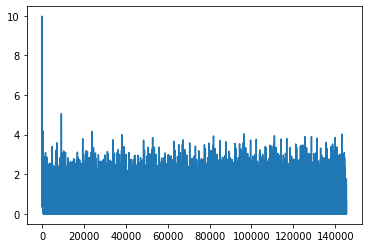

In [21]:
import matplotlib.pyplot as plt

plt.plot(training_loss_track)

## Testing

In [5]:
soft_embeddings = torch.load('../Saved_weights/Promt-Tuned_CLF__IMDB_50K/gpt2-medium/promptuned__epoch_10.pth')

In [8]:
prompt = [
    "This was an awesome movie",
    "This was a bad movie",
    "This was not a good movie",
    "That movie was garbage",
    "Iphone 7 is not a good phone",
    "Google new line of pixels are great"
]

prompt = ["<REVIEW>: " + p + " <SENTIMENT>" for p in prompt]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 40,
    # debug=True,
    get_answer_tokens=True,

    prompt_tuning = soft_embeddings,
    # track_interesting_words = [
    #     [" positive", " negative"],
    #     [" positive", " negative"]
    # ]
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

<REVIEW>: This was an awesome movie <SENTIMENT>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><REVIEW>: This was an awesome movie <SENTIMENT> positive positive positive positive positive
p(answer):  p(' positive'[3967])=0.995, p(' negative'[4633])=0.0049, p(' positively'[19888])=0.0, p(' positives'[38548])=0.0, p(' good'[922])=0.0

<REVIEW>: This was a bad movie <SENTIMENT>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><REVIEW>: This was a bad movie <SENTIMENT> negative, negative, negative
p(answer):  p(' negative'[4633])=0.9986, p(' positive'[3967])=0.0014, p(' der

In [24]:
testing_dataloader = DataLoader(test_dataset, batch_size=5)

target = []
predict = []

for reviews, sentiment in tqdm(testing_dataloader):
    tokenized_inputs = tokenizer(
        list(reviews),
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
        # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
        continue

    last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1)
    max_out_len = max(last_token_inds).item()

    with torch.no_grad():
        txt, ret_dict = model_utils.generate_fast(
            model, tokenizer,
            list(reviews),
            argmax_greedy = True,
            max_out_len= max_out_len + prefix_size + 3,
            # debug=True,
            get_answer_tokens=True,

            prompt_tuning = soft_embeddings,
        )

    for t, p in zip(list(sentiment), ret_dict['answer']):
        target.append(t)
        predict.append(p['top_token'])

    # print(txt, ret_dict['answer'])

    # break

100%|██████████| 2000/2000 [2:09:05<00:00,  3.87s/it]  


In [25]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(target, predict).ravel()

print(tp, fp)
print(fn, tn)

4371 230
338 4331


In [26]:
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
balanced_acc = (sensitivity + specificity)/2

balanced_acc

0.9388975073691381